In [2]:
import pandas as pd
import numpy as np
import graph_tool as gt
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
import plotly.graph_objects as go

In [40]:
%matplotlib inline

In [1]:
colors = ['#5175bc', '#d23a47']

## Small function to create the plots

In [4]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

### Plot parameters

In [5]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

# Load table

In [6]:
cite = pd.read_csv("../../data/processed/cites.csv")

cite = cite[(cite.t_year >= 1990) & (cite.t_year < 2020)]
cite = cite[(cite.s_year >= 1990) & (cite.s_year < 2020)]

cite = cite[cite.target != cite.source]

### Authors table

There are two author tables: 

1. One with the comparable groups A and B (`people`) and 
2. the one with the all the authors found in the RePEc repository (`all_people`).

In [7]:
people = pd.read_csv("../../data/processed/network_people.csv")
all_people = pd.read_csv("../../data/processed/people.csv")

### Places table

We use the institution to infer the place of work of the authors. We have:

1. The region (continent)
2. The sub-region (sub-continent)
3. Country 3-letter code
4. The institution's name

In [8]:
places = pd.read_csv("../../data/processed/institution.csv")

places = places[['Handle', 'Primary-Name', 'alpha-3', 'region', 'sub-region']].set_index("Handle")

### Adding place of work to people

In [9]:
all_people = pd.merge(all_people,
                  places,
                  left_on="Workplace-Institution",
                  right_index=True,
                  how="left")

# all_people = all_people[all_people.region.notna()]

### Adding gender to the citation table

We have two genders for each cite:

1. Gender of the source (`gender_s`)
3. Gender of the target (`gender`)

In [10]:
cite = pd.merge(cite,
                all_people[["Short-Id", "gender"]],
                how="left",
                left_on="target",
                right_on="Short-Id")

cite = pd.merge(cite,
                all_people[["Short-Id", "gender"]].rename(columns={"gender":"gender_s"}),
                how="left",
                left_on="source",
                right_on="Short-Id")

Let's remove the citations without the gender of the target from the table.

In [11]:
cite = cite[cite.gender.notna()]
cite = cite[cite.gender_s.notna()]

## People

In [12]:
cite_people = set(cite.source.unique()) | set(cite.target.unique())
cite_people = all_people[all_people['Short-Id'].isin(cite_people)]

In [13]:
cite_people.gender.value_counts(normalize=True)

male      0.762662
female    0.237338
Name: gender, dtype: float64

In [14]:
cite.gender_s.value_counts(normalize=True)

male      0.83079
female    0.16921
Name: gender_s, dtype: float64

In [15]:
cite.gender.value_counts(normalize=True)

male      0.87594
female    0.12406
Name: gender, dtype: float64

## In/out-degree distribution

In [16]:
in_degree = cite.groupby('target').size()

In [17]:
out_degree = cite.groupby('source').size()

In [69]:
(in_degree.quantile(.75) - in_degree.quantile(.25))

78.0

In [70]:
in_degree.mean()

113.4665015558519

In [18]:
super_cited = in_degree[in_degree > in_degree.mean() + 1.5 * (in_degree.quantile(.75) - in_degree.quantile(.25))]

In [46]:
len(super_cited) / len(in_degree)

0.11021146885120975

In [49]:
cite.shape

(3573514, 11)

In [48]:
in_degree.shape

(31494,)

In [19]:
sc_people = all_people[all_people['Short-Id'].isin(super_cited.index)]

In [19]:
sc_people.gender.value_counts(normalize=True)

male      0.889657
female    0.110343
Name: gender, dtype: float64

In [64]:
sum(super_cited) / sum(in_degree)

0.6985046091886026

In [65]:
len(super_cited)

3471

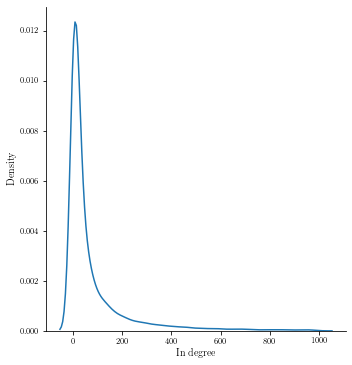

In [22]:
g = sns.displot(in_degree[in_degree <= 1000], kind='kde')
g.axes[0,0].set_xlabel(r'In degree')
g.savefig('../../figures/in_degree_distribution.pdf')

In [23]:
cite_people.shape

(36665, 9)

In [24]:
cite_people.region.unique()

array(['Americas', nan, 'Europe', 'Asia', 'Africa', 'Oceania'],
      dtype=object)

In [25]:
cite.head()

,paper,target,t_year,t_journal,source,s_year,s_journal,Short-Id_x,gender,Short-Id_y,gender_s
0,repec:aag:wpaper:v:22:y:2018:i:1:p:180-203,pal66,2018.0,repec:aag:wpaper,pmc90,2019.0,repec:gam:jsusta,pal66,male,pmc90,male
1,repec:aag:wpaper:v:22:y:2018:i:1:p:180-203,pmc90,2018.0,repec:aag:wpaper,pal66,2019.0,repec:gam:jsusta,pmc90,male,pal66,male
3,repec:abz:journl:y:2015:id:26,pba1182,2015.0,repec:abz:journl,pze104,2016.0,repec:abz:journl,pba1182,female,pze104,male
4,repec:abz:journl:y:2015:id:26,pze104,2015.0,repec:abz:journl,pba1182,2016.0,repec:abz:journl,pze104,male,pba1182,female
5,repec:acb:agenda:v:10:y:2003:i:1:p:27-41,pfi172,2003.0,repec:acb:agenda,pwh34,2010.0,repec:bla:ecorec,pfi172,male,pwh34,male


## Groups A and B

In [20]:
groups = pd.read_csv('../../data/processed/network_people.csv')

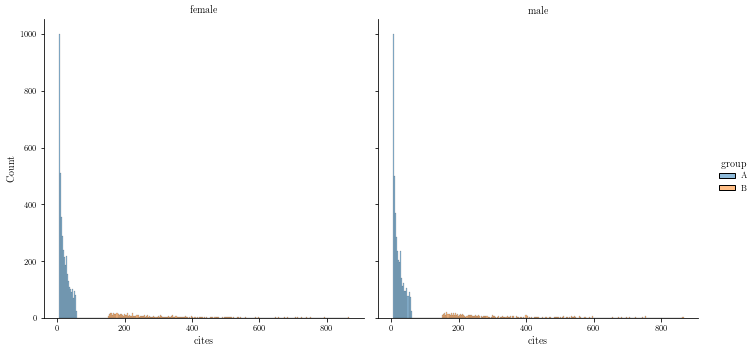

In [21]:
p = sns.displot(groups, x="cites", hue="group", col="gender")
p.set_titles(row_template = '{row_name}', col_template = '{col_name}')

In [29]:
sns.histplot?

In [24]:
groups = groups.rename(columns={'gender': 'Gender', 'cites': 'Cites'})

In [31]:
groups.groupby('group').Cites.mean()

group
A     19.605767
B    307.194524
Name: Cites, dtype: float64

In [32]:
groups.groupby('group').size()

group
A    7942
B    1388
dtype: int64

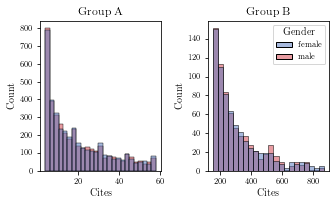

In [27]:
width = 345
fig, axs = plt.subplots(1, 2, figsize=set_size(width, fraction=1))
with sns.color_palette(colors):
    p = sns.histplot(groups[groups.group=='A'], x="Cites", hue="Gender", ax=axs[0], legend=False, stat='count')
    p.set_title('Group A')
    g = sns.histplot(groups[groups.group=='B'], x="Cites", hue="Gender", ax=axs[1], stat='count')
    g.set_title('Group B')
fig.tight_layout()
fig.savefig('../../figures/groups_dist.pdf')

## Flow chart

In [139]:
cite[cite.target.isin(people[people.group=='A']['Short-Id'].unique())].groupby('gender_s').gender.value_counts(normalize=True)

gender_s  gender
female    female    0.558899
          male      0.441101
male      male      0.513417
          female    0.486583
Name: gender, dtype: float64

In [140]:
cite[cite.target.isin(people[people.group=='B']['Short-Id'].unique())].groupby('gender_s').gender.value_counts(normalize=True)

gender_s  gender
female    female    0.554278
          male      0.445722
male      male      0.506481
          female    0.493519
Name: gender, dtype: float64

In [146]:
cite[cite.source.isin(people[people.group=='A']['Short-Id'].unique())].groupby('gender_s').gender.value_counts(normalize=True)

gender_s  gender
female    male      0.842659
          female    0.157341
male      male      0.875118
          female    0.124882
Name: gender, dtype: float64

In [145]:
cite[cite.source.isin(people[people.group=='B']['Short-Id'].unique())].groupby('gender_s').gender.value_counts(normalize=True)

gender_s  gender
female    male      0.857032
          female    0.142968
male      male      0.884939
          female    0.115061
Name: gender, dtype: float64

In [147]:
label = ["Female", "Male", "Male A", "Female A", "Male B", "Female B", "Female", "Male"]
source = [0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
target = [2, 3, 3, 2, 5, 4, 4, 5, 6, 7, 6, 7, 6, 7, 6, 7]
value = [0.441101, 0.558899, 0.513417, 0.486583, 0.554278, 0.445722, 0.506481, 0.493519,
        0.124882, 0.875118, 0.157341, 0.842659, 0.115061, 0.884939, 0.142968, 0.857032]

In [148]:
link = dict(source = source, target = target, value = value)
node = dict(label = label, pad=50, thickness=5)
data = go.Sankey(link = link, node=node)
print(data)

Sankey({
    'link': {'source': [0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5],
             'target': [2, 3, 3, 2, 5, 4, 4, 5, 6, 7, 6, 7, 6, 7, 6, 7],
             'value': [0.441101, 0.558899, 0.513417, 0.486583, 0.554278, 0.445722,
                       0.506481, 0.493519, 0.124882, 0.875118, 0.157341, 0.842659,
                       0.115061, 0.884939, 0.142968, 0.857032]},
    'node': {'label': [Female, Male, Male A, Female A, Male B, Female B, Female,
                       Male],
             'pad': 50,
             'thickness': 5}
})


In [149]:
fig = go.Figure(data)

In [150]:
fig.show()

In [157]:
cite[(cite.source.isin(people[people.group=='A']['Short-Id'].unique())) & (~cite.target.isin(super_cited.index))].groupby('gender_s').gender.value_counts(normalize=True)

gender_s  gender
female    male      0.756807
          female    0.243193
male      male      0.804796
          female    0.195204
Name: gender, dtype: float64

In [152]:
label = ["Female", "Male", "Male A", "Female A", "Female", "Male"]
source = [0, 0, 1, 1, 2, 2, 3, 3]
target = [2, 3, 3, 2, 5, 4, 4, 5]
value = [0.441101, 0.558899, 0.513417, 0.486583,
        0.124882, 0.875118, 0.157341, 0.842659]

In [153]:
link = dict(source = source, target = target, value = value)
node = dict(label = label, pad=50, thickness=5)
data = go.Sankey(link = link, node=node)
print(data)

Sankey({
    'link': {'source': [0, 0, 1, 1, 2, 2, 3, 3],
             'target': [2, 3, 3, 2, 5, 4, 4, 5],
             'value': [0.441101, 0.558899, 0.513417, 0.486583, 0.124882, 0.875118,
                       0.157341, 0.842659]},
    'node': {'label': ['Female', 'Male', 'Male A', 'Female A', 'Female', 'Male'], 'pad': 50, 'thickness': 5}
})


In [154]:
fig = go.Figure(data)

In [155]:
fig.show()

In [162]:
label = ["Female", "Male", "Male A", "Female A", "Female", "Male"]
source = [0, 0, 1, 1, 2, 2, 3, 3]
target = [2, 3, 3, 2, 5, 4, 4, 5]
value = [0.441101, 0.558899, 0.513417, 0.486583,
         0.195204, 0.804796, 0.243193, 0.756807,]

In [163]:
link = dict(source = source, target = target, value = value)
node = dict(label = label, pad=50, thickness=5)
data = go.Sankey(link = link, node=node)
print(data)

Sankey({
    'link': {'source': [0, 0, 1, 1, 2, 2, 3, 3],
             'target': [2, 3, 3, 2, 5, 4, 4, 5],
             'value': [0.441101, 0.558899, 0.513417, 0.486583, 0.195204, 0.804796,
                       0.243193, 0.756807]},
    'node': {'label': ['Female', 'Male', 'Male A', 'Female A', 'Female', 'Male'], 'pad': 50, 'thickness': 5}
})


In [164]:
fig = go.Figure(data)

In [165]:
fig.show()